In [1]:
# https://www.tensorflow.org/hub/tutorials/tf2_image_retraining

import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.7.0
Hub version: 0.12.0
GPU is available


In [6]:
model_name = "efficientnetv2-xl-21k"
model_handle = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2'
pixels = 512
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228827136/228813984 [==============================] - 5s 0us/step


In [5]:
do_fine_tuning = False

In [8]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

def build_dataset(subset):
    return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
    preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
    preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
    # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
    # image sizes are fixed when reading, and then a random zoom is applied.
    # If all training inputs are larger than image_size, one could also use
    # RandomCrop with a batch size of 1 and rebatch later.
    preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              207615832 
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 207,622,237
Trainable params: 6,405
Non-trainable params: 207,615,832
_________________________________________________________________


In [10]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [11]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/5
183/183 [==============================] - 292s 1s/step - loss: 0.9763 - accuracy: 0.8842 - val_loss: 0.8349 - val_accuracy: 0.9417
Epoch 2/5
183/183 [==============================] - 259s 1s/step - loss: 0.6812 - accuracy: 0.9360 - val_loss: 0.7158 - val_accuracy: 0.9694
Epoch 3/5
183/183 [==============================] - 258s 1s/step - loss: 0.6115 - accuracy: 0.9630 - val_loss: 0.6083 - val_accuracy: 0.9583
Epoch 4/5
183/183 [==============================] - 259s 1s/step - loss: 0.5514 - accuracy: 0.9777 - val_loss: 0.5682 - val_accuracy: 0.9569
Epoch 5/5
183/183 [==============================] - 259s 1s/step - loss: 0.5271 - accuracy: 0.9760 - val_loss: 0.5523 - val_accuracy: 0.9625


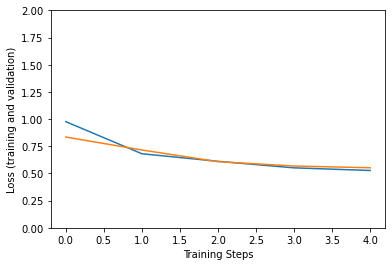

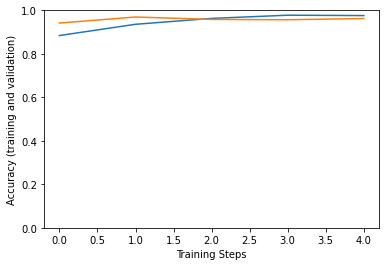

In [12]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

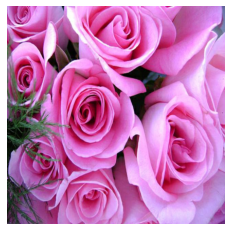

True label: roses
Predicted label: roses


In [25]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])